FileName = ImgSegmentation_01.ipynb, written to do basic image segmentation with the
Cats & Dogs data set

(https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

This is an example of Image Segmentation using the Oxford IIT Pets data set. The code is located at

    /drv3/hm3/code/python/tf2.18/tf2.18/ImgSegmentation/

The code is running in a Virtual Env under Python 3.10.12, with TF 2.18 
The data is supposed to be obtain as

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

But instead I visited Kaggle, obtained the dataset and stored it at 

/dev3/hm3/Data/ImgData/Oxford_iit_pets


In [1]:
# get the libraries ready
import os
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np

import shutil, pathlib


import tensorflow as tf
# from tensorflow import keras
import keras
from keras.utils import load_img, img_to_array
from keras.utils import array_to_img

from keras import layers

print(tf.__version__)
print(keras.__version__)
print(matplotlib.__version__)
print( tf.config.list_physical_devices('GPU') )

2025-02-22 16:33:14.693497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740241994.738629     329 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740241994.750909     329 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 16:33:14.847053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0
3.8.0
3.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
base_dat_dir = "./imgSegExcercise/Oxford_iiit_pets/"

# directrory where the pre-trained model is going to be written 
base_code_dir = "./imgSegExcercise/Playground/"

input_dir  = base_dat_dir + "images/"   # contains the 7,394 images
target_dir = base_dat_dir +  "annotations/trimaps/"

# there are 7390 files in input_img_paths
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

# there are 7390 files in target_img_paths
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])



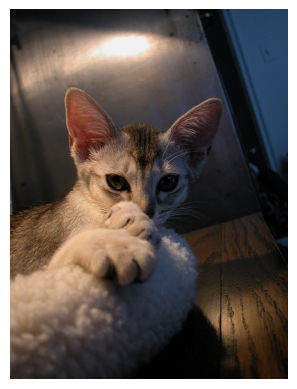

In [3]:
# image displayed is "Abyssinian_107.jpg" Image is of size 151 KBs
plt.axis("off")
# plt.imshow(load_img(input_img_paths[9]))
plt.imshow(load_img(input_img_paths[1]))

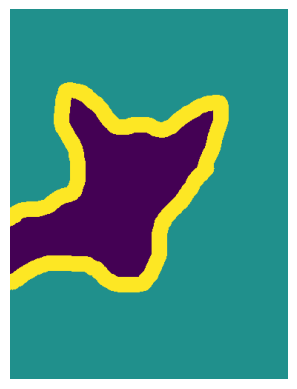

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[1], color_mode="grayscale"))
# img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [5]:
""" 
The images in the dataset have different shapes and sizes.
We must transform the images to the shape (size). 

The function load_img(source, size) takes an image from source 
and returns the image transformed to a new size using 
nearest image interpolation. 
"""

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
# train_input_imgs and train_targets contain 6390 files 
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
# val_input_imgs and val_targets contain 1000 files
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

I0000 00:00:1740242439.294374     329 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
""" 
The GPU card I was using (GeForce RTX 1060) has limited capacity to process this segmentation task under the fit parameters being used.
By reducing the batch_size from 64 to just 8, the processing could finish in 60+ minutes.
I increased the batch_size = 16. The processing does not crash but it takes too long to process.

Jasiu said he was using for his segmentation app a batch size of 2. but I also suspect the processing will take long... 
There was an error msg that suggested using  "export TF_GPU_ALLOCATOR=cuda_malloc_async " so I did that in /etc/profile

On 20231006 I installed a new RTX 3060 GPU card with 3584 GPUs and 12 GB of memory. The first thing to note is that the fit operation does not crash with
batch_size=64. The fit operation took 29 minutes and 21 secs and the results are similar to the results in the book. 
"""


model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callback_dir = base_code_dir + "oxford_pets_segmentation_01.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets, verbose=0,
                    epochs=50,
                    # epochs=20,
                    callbacks=callbacks,
                    batch_size=64,
                    # batch_size=32,
                    validation_data=(val_input_imgs, val_targets))


2025-02-22 00:28:50.977324: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3067200000 exceeds 10% of free system memory.
2025-02-22 00:28:54.190453: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3067200000 exceeds 10% of free system memory.
I0000 00:00:1740184137.180506      77 service.cc:148] XLA service 0x7e7c5c00f7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740184137.180539      77 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-22 00:28:57.242767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1740184137.274305      77 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1740184

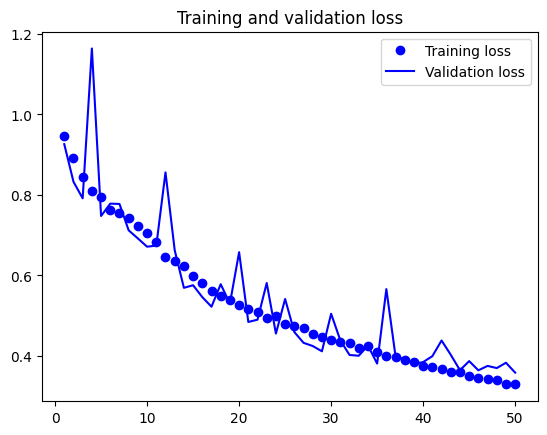

In [8]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

test_image shape =  (200, 200, 3)
test_image(array_to_img) <PIL.Image.Image image mode=RGB size=200x200 at 0x7E7E634C88D0>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


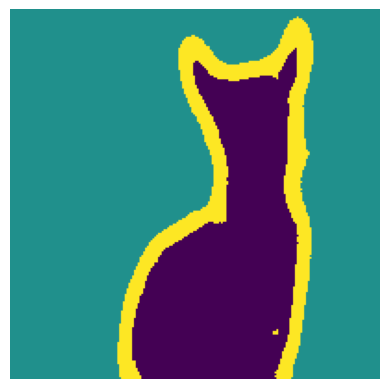

In [11]:

model = keras.models.load_model(callback_dir)

i = 1
test_image = val_input_imgs[i]
tmp = array_to_img(test_image)

print("test_image shape = ", test_image.shape)
print("test_image(array_to_img)", tmp ) 

plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)